<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/VI_DAMM_0903_lr1e_3_hd20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

In [2]:
## generate data
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 100; n_features = 2
  
  ## set truth expression means/covariances (multivariate) ##
  mu = np.random.rand(n_clusters, n_features)
  # mu = np.sort(mu, 0) ## sort expressions
  sigma = 0.001 * np.identity(n_features) ## variance-covariance matrix

  ## set truth cell size means/variances (univariate) ##
  psi = [np.random.normal(100, 25) for i in range(n_clusters)]
  #psi = np.arange(90, 90 + 5 * n_clusters, 5)
  psi = np.sort(psi, 0)
  omega = 1 ## standard deviation
  ###

  ## set latent variables distributions ##
  lambda_arr = np.random.binomial(1, .95, n_obs) # p=.95 (a cell belongs to singlet or doublet) 

  n_singlet = np.sum(lambda_arr == 1) ## number of cells in singlet clusters
  n_doublet = np.sum(lambda_arr == 0) ## number of cells in doublet clusters
  
  lambda0_arr = n_singlet / n_obs ## proportion of cells belong to singlet
  lambda1_arr = n_doublet / n_obs ## proportion of cells belong to doublet

  #pi_arr = np.sort(np.random.sample(n_clusters))
  pi_arr = np.sort(np.random.rand(n_clusters))
  pi_arr /= pi_arr.sum()

  n_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  #tau_arr = np.sort(np.random.sample(n_doublet_clusters))
  tau_arr = np.sort(np.random.rand(n_doublet_clusters))
  tau_arr /= tau_arr.sum()

  ## draw cells based on defined parameters theta1 = (mu, sigma, psi, omega) & theta2 = (lambda, pi, tau)
  x = np.zeros((n_singlet, n_features+5))
  for i in range(n_singlet):
    selected_cluster = np.random.choice(n_clusters, size = 1, p = pi_arr)[0] ## select a single cell cluster
    x[i] = np.append(np.random.multivariate_normal(mu[selected_cluster], sigma),
                     [np.random.normal(psi[selected_cluster], omega), 
                      0, selected_cluster, 0, selected_cluster + n_doublet_clusters])
  
  x[x < 0] = 1e-4
  lookups = np.triu_indices(n_clusters) # wanted indices
  xx = np.zeros((n_doublet, n_features+5))
  for i in range(n_doublet):
    selected_cluster = np.random.choice(n_doublet_clusters, p = tau_arr)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xx[i] = np.append(np.random.multivariate_normal( (mu[indx1] + mu[indx2])/2, (sigma + sigma)/2 ),
                     [np.random.normal( (psi[indx1] + psi[indx2]), omega+omega ), 
                      1, indx1, indx2, selected_cluster])
  xx[xx < 0] = 1e-4
  xxx = np.append(x, xx).reshape(n_obs, n_features+5)

  truth_theta = {
    'log_mu': np.log(mu),
    'log_sigma': np.log(sigma),
    'log_psi': np.log(psi),
    'log_omega': np.log(omega),
    "log_lambda0": np.log(lambda0_arr),
    'log_pi': np.log(pi_arr),
    'log_tau': np.log(tau_arr)
  }

  return xxx[:,:n_features], xxx[:,n_features], xxx, truth_theta

  #return torch.tensor(xxx[:,:n_features]), torch.tensor(xxx[:,n_features]), torch.tensor(xxx), [mu, sigma, psi, omega], [lambda0_arr, pi_arr, tau_arr]

In [3]:
def compute_p_y_given_z(Y, Theta):
  """ Returns NxC
  p(y_n | z_n = c)
  """
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  dist_Y = D.Normal(mu, sigma)
  return dist_Y.log_prob(Y.reshape(Y.shape[0], 1, nf)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta):
  """ Returns NxC
  p(s_n | z_n = c)
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  dist_S = D.Normal(psi, omega)
  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  mu2 = mu.reshape(1, nc, nf)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, nc, nf)
  sigma2 = (sigma2 + sigma2.permute(1,0,2)) / 2.0

  dist_Y2 = D.Normal(mu2, sigma2)
  return  dist_Y2.log_prob(Y.reshape(-1, 1, 1, nf)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(S, Theta):
  """ NxCxC
  p(s_n | gamma_n = [c,c'])
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  dist_S2 = D.Normal(psi2, omega2)
  return dist_S2.log_prob(S.reshape(-1, 1, 1))

In [4]:
class BasicForwardNet(nn.Module):
  """Encoder for when data is input without any encoding"""
  def __init__(self, input_dim, output_dim, hidden_dim = 20):
    super().__init__()
    
    self.input = nn.Linear(input_dim, hidden_dim)
    self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        
    #self.linear = nn.ModuleList(
    #    [nn.Linear(hidden_dim, hidden_dim) for i in range(n_hidden)]
    #)

    self.output = nn.Linear(hidden_dim, output_dim)
    
  def forward(self, x):
    out = F.relu(self.input(x))
    out = F.relu(self.linear1(out))
    out = self.output(out)
        
    return F.softmax(out, dim=1), F.log_softmax(out, dim=1) ## r/v/d log_r/log_v/log_d

In [5]:
def compute_joint_probs(Theta, Y, S):

  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])
  
  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  log_rzd0 = p_s_given_z + p_y_given_z + log_pi + log_delta[0]

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  log_vgd1 = p_y_given_gamma + p_s_given_gamma + log_tau + log_delta[1]

  #remove_indices = np.tril_indices(nc, -1) ## remove indices
  #log_rd1g[:, remove_indices[0], remove_indices[1]] = float("NaN")

  #q1 = r.exp() * log_rd0z #; q1[torch.isnan(q1)] = 0.0
  #q2 = v.exp() * log_rd1g #; q2[torch.isnan(q2)] = 0.0

  return log_rzd0, log_vgd1.reshape(Y.shape[0], nc*nc)

In [6]:
nc = 3; no = 1000; nf = 2

Y, S, XX, theta_true = generateData(n_clusters = nc, n_obs = no, n_features = nf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log


In [7]:
nt = 20
N_ITER = 100000
lr = 1e-3
tol = 1e-6
N_INIT = 20
P = Y.shape[1] + 1

In [8]:
%%capture
!pip install wandb --upgrade

import wandb
wandb.login()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 20453.802613334552; pi: tensor([0.4466, 0.2623, 0.2911], dtype=torch.float64)
NELBO: 2709.4492044067465; pi: tensor([0.4372, 0.2702, 0.2925], dtype=torch.float64)
NELBO: 1690.0873863661373; pi: tensor([0.4360, 0.2710, 0.2930], dtype=torch.float64)
NELBO: 1252.9325758435934; pi: tensor([0.4350, 0.2716, 0.2935], dtype=torch.float64)
NELBO: 1034.9833245592172; pi: tensor([0.4339, 0.2722, 0.2939], dtype=torch.float64)
NELBO: 897.847925154113; pi: tensor([0.4328, 0.2728, 0.2943], dtype=torch.float64)
NELBO: 813.2011035580122; pi: tensor([0.4318, 0.2734, 0.2948], dtype=torch.float64)
NELBO: 765.0589230242185; pi: tensor([0.4308, 0.2740, 0.2952], dtype=torch.float64)
NELBO: 755.1574012602437; pi: tensor([0.4298, 0.2746, 0.2956], dtype=torch.float64)
NELBO: 751.393563408772; pi: tensor([0.4288, 0.2752, 0.2960], dtype=torch.float64)
NELBO: 749.129371538324; pi: tensor([0.4278, 0.2758, 0.2964], dtype=torch.float64)
NELBO: 747.6405462522566; pi: tensor([0.4268, 0.2764, 0.2968], dtype=torch

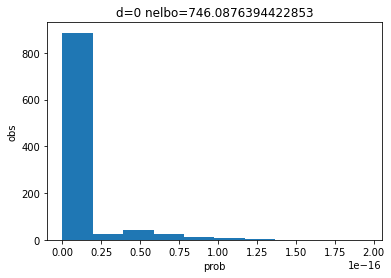

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,13011
nelbo,746.08764
entropy,-1713.57129
reconstruction_loss,-2459.65893
_runtime,174
_timestamp,1630685241
_step,13010


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▁▃▅▇▇██████████████████████████████████
reconstruction_loss,▁▅▆▇▇▇▇█████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 28320.526088881066; pi: tensor([0.4459, 0.2630, 0.2912], dtype=torch.float64)
NELBO: 2938.3176227094978; pi: tensor([0.4296, 0.2738, 0.2966], dtype=torch.float64)
NELBO: 1478.7603542994575; pi: tensor([0.4286, 0.2744, 0.2970], dtype=torch.float64)
NELBO: 1065.4569711355648; pi: tensor([0.4276, 0.2750, 0.2974], dtype=torch.float64)
NELBO: 874.749256791308; pi: tensor([0.4266, 0.2756, 0.2978], dtype=torch.float64)
NELBO: 804.7742554877202; pi: tensor([0.4256, 0.2761, 0.2982], dtype=torch.float64)
NELBO: 779.2120648837165; pi: tensor([0.4247, 0.2767, 0.2986], dtype=torch.float64)
NELBO: 764.5049706714692; pi: tensor([0.4237, 0.2773, 0.2990], dtype=torch.float64)
NELBO: 2436.2761979205357; pi: tensor([0.4228, 0.2778, 0.2994], dtype=torch.float64)
NELBO: 2398.5224315095547; pi: tensor([0.4219, 0.2784, 0.2997], dtype=torch.float64)
NELBO: 2391.8809021648185; pi: tensor([0.4210, 0.2789, 0.3001], dtype=torch.float64)
NELBO: 2388.590552806251; pi: tensor([0.4200, 0.2795, 0.3005], dtype=t

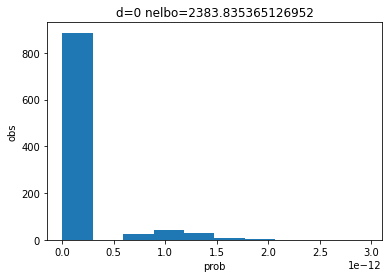

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,16768
nelbo,2383.83537
entropy,-1098.61194
reconstruction_loss,-3482.4473
_runtime,225
_timestamp,1630685471
_step,16767


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
entropy,▁▇██████████████████████████████████████
reconstruction_loss,▁▅▆▇▇█████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 22948.60486799229; pi: tensor([0.2623, 0.4466, 0.2911], dtype=torch.float64)
NELBO: 2616.2020580562175; pi: tensor([0.1163, 0.2083, 0.6754], dtype=torch.float64)
NELBO: 1594.9467518750735; pi: tensor([0.0505, 0.0900, 0.8595], dtype=torch.float64)
NELBO: 1388.4558900410861; pi: tensor([0.0252, 0.0448, 0.9300], dtype=torch.float64)
NELBO: 1334.8729213135266; pi: tensor([0.0139, 0.0246, 0.9615], dtype=torch.float64)
NELBO: 1312.5137355570018; pi: tensor([0.0082, 0.0144, 0.9775], dtype=torch.float64)
NELBO: -231.68161248993783; pi: tensor([0.0505, 0.0181, 0.9314], dtype=torch.float64)
NELBO: -337.3214523098495; pi: tensor([0.1046, 0.0126, 0.8828], dtype=torch.float64)
NELBO: -344.7852235474072; pi: tensor([0.1104, 0.0072, 0.8824], dtype=torch.float64)
NELBO: -348.36086857268606; pi: tensor([0.1119, 0.0043, 0.8838], dtype=torch.float64)
NELBO: -350.40435957275713; pi: tensor([0.1127, 0.0027, 0.8846], dtype=torch.float64)
NELBO: -351.60348458128124; pi: tensor([0.1132, 0.0017, 0.8851]

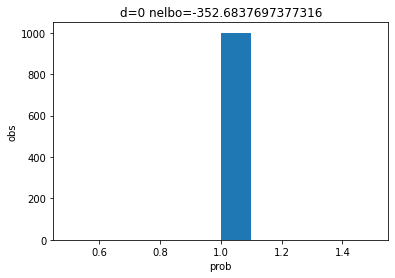

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12515
nelbo,-352.68377
entropy,-2197.22656
reconstruction_loss,-1844.54279
_runtime,164
_timestamp,1630685639
_step,12514


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,████████████████▆▁██████████████████████
reconstruction_loss,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 77836.30185404725; pi: tensor([0.4459, 0.2630, 0.2912], dtype=torch.float64)
NELBO: 3496.486930188813; pi: tensor([0.4411, 0.2693, 0.2896], dtype=torch.float64)
NELBO: 1703.6365279690322; pi: tensor([0.4399, 0.2699, 0.2902], dtype=torch.float64)
NELBO: 1247.1962429034443; pi: tensor([0.4388, 0.2706, 0.2906], dtype=torch.float64)
NELBO: 955.8554249549284; pi: tensor([0.4377, 0.2712, 0.2911], dtype=torch.float64)
NELBO: 507.06000627721914; pi: tensor([0.4366, 0.2718, 0.2916], dtype=torch.float64)
NELBO: 166.5126788905891; pi: tensor([0.4355, 0.2725, 0.2920], dtype=torch.float64)
NELBO: 74.02359831323633; pi: tensor([0.4344, 0.2731, 0.2925], dtype=torch.float64)
NELBO: 61.690013717850206; pi: tensor([0.4334, 0.2737, 0.2929], dtype=torch.float64)
NELBO: 56.925716983053235; pi: tensor([0.4324, 0.2743, 0.2934], dtype=torch.float64)
NELBO: 53.91653691423721; pi: tensor([0.4313, 0.2749, 0.2938], dtype=torch.float64)
NELBO: 52.168786797110215; pi: tensor([0.4303, 0.2754, 0.2942], dtype=t

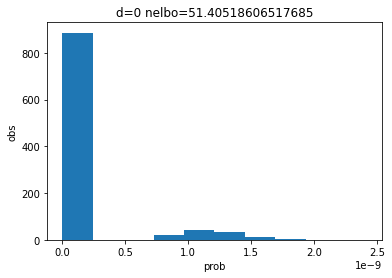

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,11592
nelbo,51.40519
entropy,-1444.49036
reconstruction_loss,-1495.89554
_runtime,153
_timestamp,1630685797
_step,11591


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▃▄▃▁▃▃▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
reconstruction_loss,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 61825.41688473553; pi: tensor([0.4459, 0.2912, 0.2630], dtype=torch.float64)
NELBO: 5187.891985638904; pi: tensor([0.4381, 0.2874, 0.2745], dtype=torch.float64)
NELBO: 1818.3054679074266; pi: tensor([0.4366, 0.2881, 0.2753], dtype=torch.float64)
NELBO: 1336.9903978177376; pi: tensor([0.4356, 0.2886, 0.2759], dtype=torch.float64)
NELBO: 1168.1498981979998; pi: tensor([0.4345, 0.2890, 0.2764], dtype=torch.float64)
NELBO: 1051.157956279008; pi: tensor([0.4335, 0.2895, 0.2770], dtype=torch.float64)
NELBO: 928.4581694554422; pi: tensor([0.4324, 0.2900, 0.2776], dtype=torch.float64)
NELBO: 818.7353973150853; pi: tensor([0.4314, 0.2904, 0.2782], dtype=torch.float64)
NELBO: 766.6188372872884; pi: tensor([0.4304, 0.2909, 0.2787], dtype=torch.float64)
NELBO: 752.2351259220582; pi: tensor([0.4294, 0.2914, 0.2793], dtype=torch.float64)
NELBO: 748.5774034828382; pi: tensor([0.4284, 0.2918, 0.2798], dtype=torch.float64)
NELBO: 747.1813924449407; pi: tensor([0.4274, 0.2922, 0.2803], dtype=torc

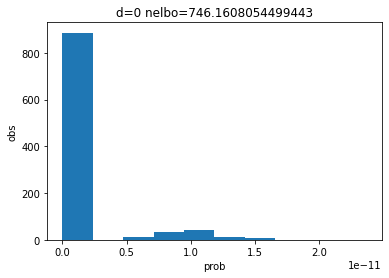

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12285
nelbo,746.16081
entropy,-1382.71057
reconstruction_loss,-2128.87138
_runtime,167
_timestamp,1630685970
_step,12284


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▇██▇▁▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅
reconstruction_loss,▁▄▅▆▆▇▇▇▇▇██████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 40136.22052059719; pi: tensor([0.4458, 0.2624, 0.2917], dtype=torch.float64)
NELBO: 2436.9055511753504; pi: tensor([0.0982, 0.7701, 0.1317], dtype=torch.float64)
NELBO: 1151.0961755324824; pi: tensor([0.0386, 0.9132, 0.0482], dtype=torch.float64)
NELBO: 547.3877176935425; pi: tensor([0.0191, 0.9576, 0.0233], dtype=torch.float64)
NELBO: 476.2608428659496; pi: tensor([0.0105, 0.9767, 0.0127], dtype=torch.float64)
NELBO: -201.83529733039518; pi: tensor([0.0062, 0.9864, 0.0074], dtype=torch.float64)
NELBO: -600.3890031622547; pi: tensor([0.0037, 0.9918, 0.0045], dtype=torch.float64)
NELBO: -713.2312934014021; pi: tensor([0.0023, 0.9950, 0.0027], dtype=torch.float64)
NELBO: -749.3988316224932; pi: tensor([0.0014, 0.9969, 0.0017], dtype=torch.float64)
NELBO: -764.967996552782; pi: tensor([9.0026e-04, 9.9803e-01, 1.0724e-03], dtype=torch.float64)
NELBO: -770.3517762385977; pi: tensor([5.6735e-04, 9.9876e-01, 6.7539e-04], dtype=torch.float64)
NELBO: -773.2727060889999; pi: tensor([3.584

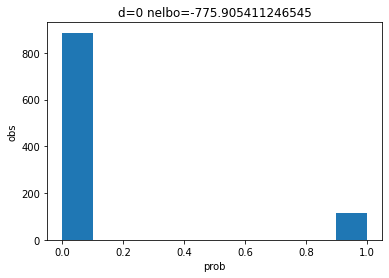

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12973
nelbo,-775.90541
entropy,-1220.20166
reconstruction_loss,-444.29625
_runtime,177
_timestamp,1630686151
_step,12972


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▂▇▅▃▃▃▂▂▂▂▂▂▁▁▃▅▆▇▇█████████████████████
reconstruction_loss,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 39788.77467696068; pi: tensor([0.2627, 0.4463, 0.2909], dtype=torch.float64)
NELBO: 2448.88318358985; pi: tensor([0.1155, 0.2040, 0.6805], dtype=torch.float64)
NELBO: 1553.4125183326132; pi: tensor([0.0499, 0.0878, 0.8623], dtype=torch.float64)
NELBO: 1382.9153249078736; pi: tensor([0.0250, 0.0437, 0.9314], dtype=torch.float64)
NELBO: 1335.6527113306083; pi: tensor([0.0138, 0.0240, 0.9622], dtype=torch.float64)
NELBO: 1314.1007765081808; pi: tensor([0.0080, 0.0140, 0.9780], dtype=torch.float64)
NELBO: 1302.7481072722958; pi: tensor([0.0049, 0.0084, 0.9866], dtype=torch.float64)
NELBO: 1295.8205701817656; pi: tensor([0.0030, 0.0052, 0.9918], dtype=torch.float64)
NELBO: 1291.6666641657162; pi: tensor([0.0019, 0.0032, 0.9949], dtype=torch.float64)
NELBO: 1289.1221421825253; pi: tensor([0.0012, 0.0020, 0.9968], dtype=torch.float64)
NELBO: 1287.542690873754; pi: tensor([7.4200e-04, 1.2608e-03, 9.9800e-01], dtype=torch.float64)
trial: 6 NELBO: 1286.6388598754415


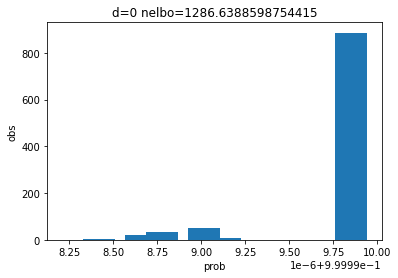

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10887
nelbo,1286.63886
entropy,-2197.22437
reconstruction_loss,-3483.86323
_runtime,146
_timestamp,1630686301
_step,10886


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▄▆▇▇▇██████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 37779.743542874734; pi: tensor([0.4456, 0.2628, 0.2916], dtype=torch.float64)
NELBO: 2645.7111154761133; pi: tensor([0.1977, 0.1171, 0.6853], dtype=torch.float64)
NELBO: 1594.5484362690186; pi: tensor([0.0854, 0.0508, 0.8638], dtype=torch.float64)
NELBO: 1386.481953680442; pi: tensor([0.0426, 0.0254, 0.9320], dtype=torch.float64)
NELBO: 1334.0026771798039; pi: tensor([0.0235, 0.0140, 0.9625], dtype=torch.float64)
NELBO: 1313.286035011975; pi: tensor([0.0137, 0.0082, 0.9782], dtype=torch.float64)
NELBO: 1301.9522783575953; pi: tensor([0.0082, 0.0049, 0.9868], dtype=torch.float64)
trial: 7 NELBO: 1296.275362416974


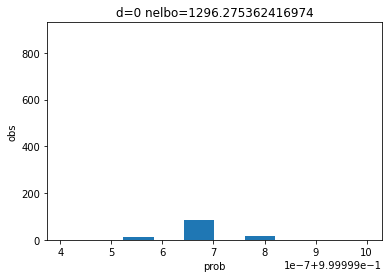

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,6819
nelbo,1296.27536
entropy,-2197.43823
reconstruction_loss,-3493.71359
_runtime,92
_timestamp,1630686398
_step,6818


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▃▅▆▆▇▇▇▇███████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 15955.627223873227; pi: tensor([0.2624, 0.4458, 0.2918], dtype=torch.float64)
NELBO: 575.2814474797215; pi: tensor([0.1523, 0.1995, 0.6482], dtype=torch.float64)
NELBO: -63.07474299454316; pi: tensor([0.1076, 0.0901, 0.8023], dtype=torch.float64)
NELBO: -258.09330677545995; pi: tensor([0.1059, 0.0470, 0.8471], dtype=torch.float64)
NELBO: -312.7725670674595; pi: tensor([0.1094, 0.0266, 0.8640], dtype=torch.float64)
NELBO: -331.11256836454936; pi: tensor([0.1113, 0.0158, 0.8729], dtype=torch.float64)
NELBO: -340.0724935140129; pi: tensor([0.1124, 0.0096, 0.8780], dtype=torch.float64)
NELBO: -345.32559781377495; pi: tensor([0.1130, 0.0059, 0.8811], dtype=torch.float64)
trial: 8 NELBO: -345.2584598883425


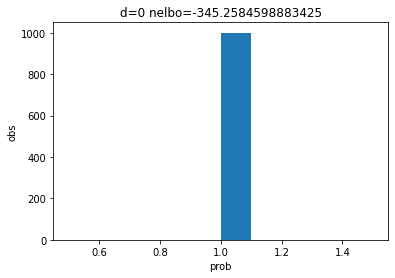

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,7036
nelbo,-345.25846
entropy,-2197.00439
reconstruction_loss,-1851.74593
_runtime,96
_timestamp,1630686499
_step,7035


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▁▆█████████████████████████████████████
reconstruction_loss,▁▄▆▇▇▇▇█████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 23849.65850464318; pi: tensor([0.4466, 0.2623, 0.2911], dtype=torch.float64)
NELBO: 2475.226713373807; pi: tensor([0.2039, 0.1142, 0.6819], dtype=torch.float64)
NELBO: 1562.1436927008303; pi: tensor([0.0874, 0.0494, 0.8632], dtype=torch.float64)
NELBO: 1382.2288469423602; pi: tensor([0.0435, 0.0247, 0.9318], dtype=torch.float64)
NELBO: 1334.1832495857293; pi: tensor([0.0239, 0.0136, 0.9625], dtype=torch.float64)
NELBO: 1313.3294009092756; pi: tensor([0.0139, 0.0079, 0.9781], dtype=torch.float64)
NELBO: 1301.9679284320073; pi: tensor([0.0084, 0.0048, 0.9868], dtype=torch.float64)
NELBO: 1295.3819013883613; pi: tensor([0.0051, 0.0030, 0.9919], dtype=torch.float64)
NELBO: 1291.6818355522223; pi: tensor([0.0032, 0.0018, 0.9950], dtype=torch.float64)
NELBO: 1288.804740245792; pi: tensor([0.0020, 0.0012, 0.9968], dtype=torch.float64)
NELBO: 1284.1988936697499; pi: tensor([1.2979e-03, 8.3018e-04, 9.9787e-01], dtype=torch.float64)
NELBO: -283.43354789521686; pi: tensor([0.0040, 0.0405, 

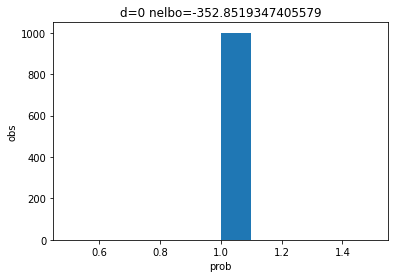

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,14398
nelbo,-352.85193
entropy,-2197.23682
reconstruction_loss,-1844.38488
_runtime,193
_timestamp,1630686697
_step,14397


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▄▃▃▃▂▁▃▄▄▄▄▄▄▄▄▄▄
reconstruction_loss,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 73805.32453170643; pi: tensor([0.2912, 0.2630, 0.4459], dtype=torch.float64)
NELBO: 2851.753980963671; pi: tensor([0.6919, 0.1171, 0.1910], dtype=torch.float64)
NELBO: 1041.0730961907939; pi: tensor([0.8594, 0.0535, 0.0870], dtype=torch.float64)
NELBO: 611.0968119927738; pi: tensor([0.9285, 0.0273, 0.0442], dtype=torch.float64)
NELBO: 410.53268005955374; pi: tensor([0.9604, 0.0151, 0.0245], dtype=torch.float64)
NELBO: 330.6270683649889; pi: tensor([0.9769, 0.0089, 0.0143], dtype=torch.float64)
NELBO: 313.9575583254275; pi: tensor([0.9860, 0.0053, 0.0086], dtype=torch.float64)
NELBO: 46.56357360343827; pi: tensor([0.9914, 0.0033, 0.0053], dtype=torch.float64)
NELBO: -63.69216038177342; pi: tensor([0.9947, 0.0020, 0.0033], dtype=torch.float64)
NELBO: -71.0629756745684; pi: tensor([0.9967, 0.0013, 0.0021], dtype=torch.float64)
NELBO: -74.00121040049339; pi: tensor([9.9790e-01, 8.0759e-04, 1.2932e-03], dtype=torch.float64)
NELBO: -79.46425373543912; pi: tensor([9.9867e-01, 5.0974e-0

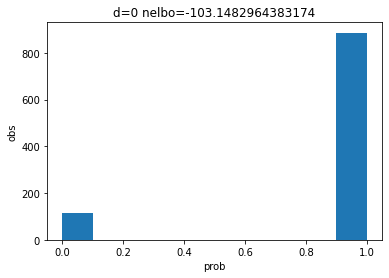

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,25810
nelbo,-103.1483
entropy,-1947.14587
reconstruction_loss,-1843.99758
_runtime,347
_timestamp,1630687050
_step,25809


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▅▇▅▅▅▅▅▅▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▄▇▇████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 22976.63794437413; pi: tensor([0.2911, 0.2623, 0.4466], dtype=torch.float64)
NELBO: 2680.2568797849526; pi: tensor([0.6793, 0.1162, 0.2045], dtype=torch.float64)
NELBO: 1613.5536769207665; pi: tensor([0.8613, 0.0504, 0.0883], dtype=torch.float64)
NELBO: 1391.617789591467; pi: tensor([0.9308, 0.0252, 0.0440], dtype=torch.float64)
NELBO: 1334.7971685777547; pi: tensor([0.9619, 0.0139, 0.0242], dtype=torch.float64)
NELBO: 1313.449280595673; pi: tensor([0.9778, 0.0081, 0.0141], dtype=torch.float64)
NELBO: 1301.3549404319838; pi: tensor([0.9866, 0.0049, 0.0085], dtype=torch.float64)
NELBO: -217.76681730450468; pi: tensor([0.9461, 0.0407, 0.0132], dtype=torch.float64)
NELBO: -340.82961361501634; pi: tensor([0.8854, 0.1049, 0.0097], dtype=torch.float64)
NELBO: -346.95868703736164; pi: tensor([0.8834, 0.1112, 0.0054], dtype=torch.float64)
trial: 11 NELBO: -347.27217132444116


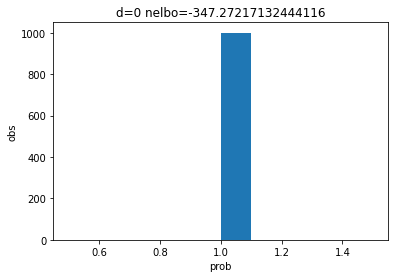

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,9025
nelbo,-347.27217
entropy,-2197.24951
reconstruction_loss,-1849.97734
_runtime,122
_timestamp,1630687179
_step,9024


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
entropy,████████████████████████████▁███████████
reconstruction_loss,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 18932.662510487833; pi: tensor([0.4463, 0.2622, 0.2915], dtype=torch.float64)
NELBO: 642.5927893588637; pi: tensor([0.1999, 0.1489, 0.6512], dtype=torch.float64)
NELBO: -21.128501423821945; pi: tensor([0.0915, 0.1090, 0.7995], dtype=torch.float64)
NELBO: -262.02167517543353; pi: tensor([0.0483, 0.1043, 0.8474], dtype=torch.float64)
NELBO: -313.01466637954627; pi: tensor([0.0276, 0.1081, 0.8643], dtype=torch.float64)
NELBO: -329.8739100997525; pi: tensor([0.0164, 0.1106, 0.8730], dtype=torch.float64)
NELBO: -339.2893750039284; pi: tensor([0.0100, 0.1120, 0.8780], dtype=torch.float64)
NELBO: -344.8366613942019; pi: tensor([0.0062, 0.1128, 0.8810], dtype=torch.float64)
NELBO: -348.19081210999343; pi: tensor([0.0039, 0.1132, 0.8829], dtype=torch.float64)
NELBO: -350.2524979564423; pi: tensor([0.0024, 0.1135, 0.8841], dtype=torch.float64)
NELBO: -351.5442408453498; pi: tensor([0.0015, 0.1137, 0.8848], dtype=torch.float64)
NELBO: -352.35256275613915; pi: tensor([0.0010, 0.1138, 0.8852

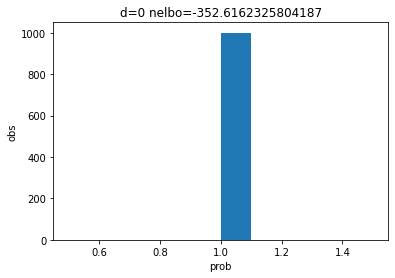

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,11457
nelbo,-352.61623
entropy,-2197.22461
reconstruction_loss,-1844.60838
_runtime,154
_timestamp,1630687338
_step,11456


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▇▁▆▇███████████████████████████████████
reconstruction_loss,▁▃▇▇▇███████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 49960.258253284774; pi: tensor([0.4463, 0.2627, 0.2909], dtype=torch.float64)
NELBO: 2275.849737804936; pi: tensor([0.2196, 0.1141, 0.6663], dtype=torch.float64)
NELBO: 1522.156105217326; pi: tensor([0.0943, 0.0492, 0.8565], dtype=torch.float64)
NELBO: 1380.2938760191396; pi: tensor([0.0468, 0.0245, 0.9287], dtype=torch.float64)
NELBO: 1335.936390985898; pi: tensor([0.0256, 0.0135, 0.9609], dtype=torch.float64)
NELBO: 1314.514479294026; pi: tensor([0.0149, 0.0079, 0.9772], dtype=torch.float64)
NELBO: 1302.6815490261743; pi: tensor([0.0090, 0.0047, 0.9863], dtype=torch.float64)
NELBO: 1295.797686327152; pi: tensor([0.0055, 0.0029, 0.9916], dtype=torch.float64)
NELBO: 1291.6578269937968; pi: tensor([0.0034, 0.0018, 0.9948], dtype=torch.float64)
NELBO: 1289.1173995758772; pi: tensor([0.0021, 0.0011, 0.9967], dtype=torch.float64)
NELBO: 1287.5396717380586; pi: tensor([1.3429e-03, 7.1598e-04, 9.9794e-01], dtype=torch.float64)
NELBO: 1286.5519318180718; pi: tensor([8.4649e-04, 4.5203e

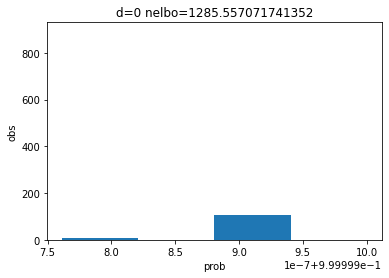

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12934
nelbo,1285.55707
entropy,-2197.2251
reconstruction_loss,-3482.78217
_runtime,173
_timestamp,1630687517
_step,12933


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▄▆▇▇███████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 41537.64478340833; pi: tensor([0.4466, 0.2623, 0.2911], dtype=torch.float64)
NELBO: 4478.078147272184; pi: tensor([0.4485, 0.2618, 0.2897], dtype=torch.float64)
NELBO: 2901.6195937283956; pi: tensor([0.3918, 0.2988, 0.3094], dtype=torch.float64)
NELBO: 2565.529087470298; pi: tensor([0.3496, 0.3242, 0.3261], dtype=torch.float64)
NELBO: 2472.6968041405817; pi: tensor([0.3495, 0.3243, 0.3262], dtype=torch.float64)
NELBO: 2323.2537085799904; pi: tensor([0.3493, 0.3244, 0.3263], dtype=torch.float64)
NELBO: 1238.55324411656; pi: tensor([0.3492, 0.3245, 0.3263], dtype=torch.float64)
NELBO: 857.8298171100842; pi: tensor([0.3490, 0.3246, 0.3264], dtype=torch.float64)
NELBO: 771.7137253957649; pi: tensor([0.3488, 0.3247, 0.3265], dtype=torch.float64)
NELBO: 755.9434061113002; pi: tensor([0.3487, 0.3248, 0.3265], dtype=torch.float64)
NELBO: 751.5348632084924; pi: tensor([0.3485, 0.3249, 0.3266], dtype=torch.float64)
NELBO: 749.027882554109; pi: tensor([0.3484, 0.3249, 0.3267], dtype=torch.

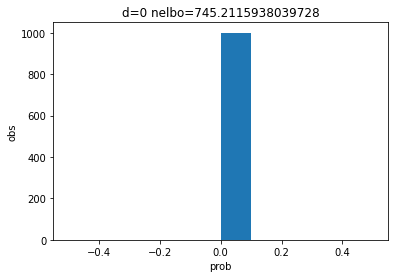

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,16998
nelbo,745.21159
entropy,-1703.76697
reconstruction_loss,-2448.97856
_runtime,221
_timestamp,1630687742
_step,16997


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▆▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▂▄▅▅▅▅▅▅▄▄▄████████████████████████████
reconstruction_loss,▁▃▅▆▆▇▇▇▇▇▇▇▇███████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 25509.67735527919; pi: tensor([0.4458, 0.2624, 0.2918], dtype=torch.float64)
NELBO: 2432.1937973264767; pi: tensor([0.1876, 0.1074, 0.7050], dtype=torch.float64)
NELBO: 1547.8519393058527; pi: tensor([0.0794, 0.0461, 0.8745], dtype=torch.float64)
NELBO: 1376.2083206437756; pi: tensor([0.0395, 0.0231, 0.9374], dtype=torch.float64)
NELBO: 1330.7735767700824; pi: tensor([0.0217, 0.0128, 0.9655], dtype=torch.float64)
NELBO: 1311.5905129815346; pi: tensor([0.0127, 0.0075, 0.9799], dtype=torch.float64)
NELBO: 1300.9614397043297; pi: tensor([0.0076, 0.0045, 0.9878], dtype=torch.float64)
NELBO: 1294.737289511886; pi: tensor([0.0047, 0.0028, 0.9925], dtype=torch.float64)
NELBO: 1290.9857046279299; pi: tensor([0.0029, 0.0017, 0.9953], dtype=torch.float64)
NELBO: 1288.6639923279063; pi: tensor([0.0018, 0.0011, 0.9971], dtype=torch.float64)
NELBO: 1287.0653392958739; pi: tensor([1.1535e-03, 7.0023e-04, 9.9815e-01], dtype=torch.float64)
NELBO: 1286.7167869715054; pi: tensor([8.0307e-04, 6.70

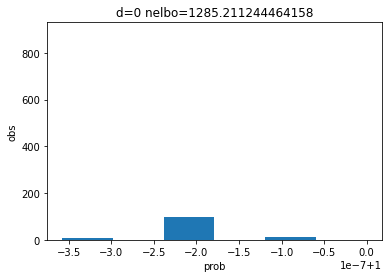

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,14543
nelbo,1285.21124
entropy,-2197.2229
reconstruction_loss,-3482.43414
_runtime,188
_timestamp,1630687935
_step,14542


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁███▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▆▅▂▇▇▇▇▇▇▇▇▇▇▇
reconstruction_loss,▁▅▇▇████████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 17509.780413234224; pi: tensor([0.4458, 0.2624, 0.2918], dtype=torch.float64)
NELBO: 1549.7015512959501; pi: tensor([0.1963, 0.5517, 0.2521], dtype=torch.float64)
NELBO: 1053.4811429959059; pi: tensor([0.0856, 0.7936, 0.1208], dtype=torch.float64)
NELBO: 887.0881656698643; pi: tensor([0.0424, 0.8938, 0.0638], dtype=torch.float64)
NELBO: 823.000474742094; pi: tensor([0.0242, 0.9316, 0.0442], dtype=torch.float64)
NELBO: 799.3907595394421; pi: tensor([0.0151, 0.9466, 0.0383], dtype=torch.float64)
NELBO: 781.4233458724543; pi: tensor([0.0099, 0.9509, 0.0392], dtype=torch.float64)
NELBO: 768.0051810993009; pi: tensor([0.0064, 0.9517, 0.0418], dtype=torch.float64)
NELBO: 1301.213239803522; pi: tensor([0.0027, 0.9856, 0.0117], dtype=torch.float64)
NELBO: 1292.6723360214305; pi: tensor([0.0015, 0.9932, 0.0053], dtype=torch.float64)
NELBO: 1289.2982523124201; pi: tensor([9.5677e-04, 9.9618e-01, 2.8657e-03], dtype=torch.float64)
NELBO: 1287.531272727631; pi: tensor([6.1326e-04, 9.9772e-01

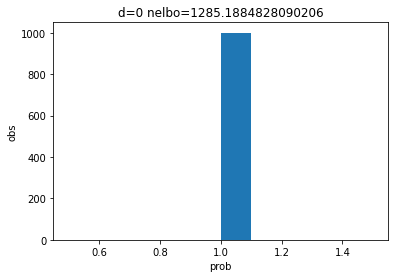

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,15507
nelbo,1285.18848
entropy,-2197.22461
reconstruction_loss,-3482.41309
_runtime,203
_timestamp,1630688142
_step,15506


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▆▁▃▄▅▇▇█████████████████████████████████
reconstruction_loss,▁▆▇▇██████████████▇█████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 68518.30516244206; pi: tensor([0.4459, 0.2630, 0.2912], dtype=torch.float64)
NELBO: 4072.1310519864655; pi: tensor([0.4411, 0.2695, 0.2894], dtype=torch.float64)
NELBO: 2568.3366951168427; pi: tensor([0.4398, 0.2703, 0.2900], dtype=torch.float64)
NELBO: 2120.0860014165096; pi: tensor([0.4385, 0.2709, 0.2905], dtype=torch.float64)
NELBO: 2001.8158630778485; pi: tensor([0.4374, 0.2716, 0.2910], dtype=torch.float64)
NELBO: 1936.5153891463951; pi: tensor([0.4363, 0.2722, 0.2915], dtype=torch.float64)
NELBO: 1903.7372378583595; pi: tensor([0.4352, 0.2728, 0.2920], dtype=torch.float64)
NELBO: 1884.2199805735572; pi: tensor([0.4341, 0.2735, 0.2925], dtype=torch.float64)
NELBO: 1870.2448671505153; pi: tensor([0.4330, 0.2741, 0.2929], dtype=torch.float64)
NELBO: 1863.569589304766; pi: tensor([0.4319, 0.2747, 0.2934], dtype=torch.float64)
NELBO: 1860.3622377618622; pi: tensor([0.4308, 0.2753, 0.2939], dtype=torch.float64)
NELBO: 1858.6593667502634; pi: tensor([0.4298, 0.2759, 0.2943], dty

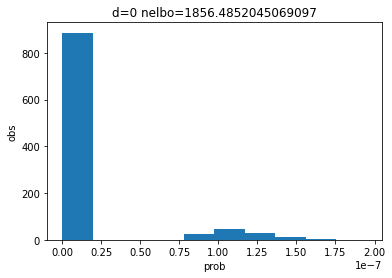

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,14020
nelbo,1856.4852
entropy,-1790.81799
reconstruction_loss,-3647.3032
_runtime,183
_timestamp,1630688330
_step,14019


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▃▁▂▂▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
reconstruction_loss,▁▅▇▇▇▇██████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 22427.685323073198; pi: tensor([0.2623, 0.4466, 0.2911], dtype=torch.float64)
NELBO: 2494.33130028086; pi: tensor([0.1139, 0.2108, 0.6752], dtype=torch.float64)
NELBO: 1565.4809940437513; pi: tensor([0.0493, 0.0907, 0.8601], dtype=torch.float64)
NELBO: 1382.7729705263364; pi: tensor([0.0246, 0.0451, 0.9303], dtype=torch.float64)
NELBO: 1333.9529140162017; pi: tensor([0.0136, 0.0248, 0.9617], dtype=torch.float64)
NELBO: 1313.2502385509542; pi: tensor([0.0079, 0.0144, 0.9777], dtype=torch.float64)
NELBO: 1301.4629769650592; pi: tensor([0.0048, 0.0087, 0.9865], dtype=torch.float64)
NELBO: 1296.742804150976; pi: tensor([0.0039, 0.0057, 0.9904], dtype=torch.float64)
NELBO: 1292.0681921778346; pi: tensor([0.0023, 0.0034, 0.9943], dtype=torch.float64)
NELBO: 1289.2394885422177; pi: tensor([0.0014, 0.0021, 0.9965], dtype=torch.float64)
NELBO: -51.32430834408706; pi: tensor([0.0097, 0.0037, 0.9866], dtype=torch.float64)
NELBO: -340.0702460204011; pi: tensor([0.0802, 0.0042, 0.9156], dtyp

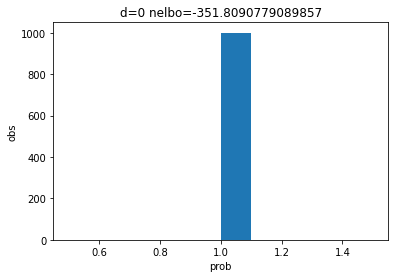

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12552
nelbo,-351.80908
entropy,-2197.22705
reconstruction_loss,-1845.41797
_runtime,166
_timestamp,1630688501
_step,12551


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
entropy,▇████████████████▇▇▆▁█████████▇▇▇███████
reconstruction_loss,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 33752.86430030949; pi: tensor([0.4466, 0.2623, 0.2911], dtype=torch.float64)
NELBO: 2546.4293623849226; pi: tensor([0.2104, 0.1161, 0.6735], dtype=torch.float64)
NELBO: 1572.6881134648934; pi: tensor([0.0909, 0.0503, 0.8588], dtype=torch.float64)
NELBO: 1384.5754174657682; pi: tensor([0.0452, 0.0251, 0.9296], dtype=torch.float64)
NELBO: 1335.076418084459; pi: tensor([0.0248, 0.0139, 0.9613], dtype=torch.float64)
NELBO: 1314.014378469933; pi: tensor([0.0145, 0.0081, 0.9775], dtype=torch.float64)
NELBO: 1302.3911200540952; pi: tensor([0.0087, 0.0049, 0.9864], dtype=torch.float64)
NELBO: 1295.5896904893375; pi: tensor([0.0053, 0.0030, 0.9917], dtype=torch.float64)
NELBO: 1291.6250956556723; pi: tensor([0.0033, 0.0019, 0.9948], dtype=torch.float64)
NELBO: 1289.0767846170415; pi: tensor([0.0021, 0.0012, 0.9967], dtype=torch.float64)
NELBO: 1287.511409358006; pi: tensor([1.3036e-03, 7.5322e-04, 9.9794e-01], dtype=torch.float64)
NELBO: 1286.5336977539582; pi: tensor([8.2111e-04, 4.7532

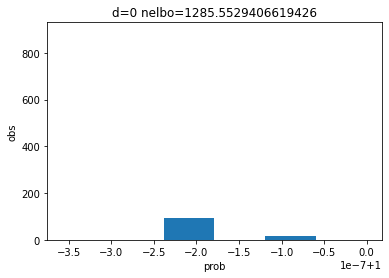

In [9]:
for trial in range(nt):
  
  Y = np.array(Y)
  S = np.array(S)
  kms = [KMeans(nc).fit(Y) for i in range(N_INIT)]
  inertias = [k.inertia_ for k in kms]
  km = kms[np.argmin(np.array(inertias))] ## selected "best" kmeans based on inertia score
  init_labels = km.labels_
  
  mu_init = np.array([Y[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
  sigma_init = np.array([Y[init_labels == i,:].std(0) for i in np.unique(init_labels)])
  psi_init = np.array([S[init_labels == i].mean() for i in np.unique(init_labels)])
  omega_init = np.array([S[init_labels == i].std() for i in np.unique(init_labels)])
  pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
  tau_init = np.ones((nc,nc))
  tau_init = tau_init / tau_init.sum()

  Theta = {
    'log_mu': np.log(mu_init) + 0.05 * np.random.randn(mu_init.shape[0], mu_init.shape[1]),
    'log_sigma': np.log(sigma_init), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init),
    'log_omega': np.log(omega_init),
    "is_delta": F.log_softmax(torch.tensor([0.95, 1-0.95])),
    'is_pi': F.log_softmax(torch.tensor(pi_init)),
    'is_tau': F.log_softmax(torch.tensor(tau_init))
  }
  Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}

  #Theta['is_delta'].requires_grad = False
  #Theta['is_pi'].requires_grad = False
  #Theta['is_tau'].requires_grad = False

  r_net = BasicForwardNet(P, nc)
  v_net = BasicForwardNet(P, nc ** 2)
  d_net = BasicForwardNet(P, 2)

  Y = torch.tensor(Y)
  S = torch.tensor(S)
  YS = torch.hstack((Y,S.reshape(-1,1))).float()

  params = list(Theta.values()) + list(r_net.parameters()) + list(v_net.parameters()) + list(d_net.parameters())
  opt = optim.AdamW(params, lr=lr)

  wandb.init(project='jett-vi_lr1e-3_hd20',
           config={
    "N_EPOCHS": N_ITER,
    "LR": lr,
    "TOL": tol,
    'MODEL_TYPE': 'vi',
    'DATA_TYPE': 'toy_data'
  })

  loss = []
  for i in range(N_ITER):
  
    opt.zero_grad()
    r, log_r = r_net(YS)
    v, log_v = v_net(YS)
    d, log_d = d_net(YS)
  
    ## row sums to 1 (from neural net)
    log_q0 = log_d[:,0].reshape(-1,1) + log_r ## like r in em version
    log_q1 = log_d[:,1].reshape(-1,1) + log_v ## like v in em version
    
    log_rzd0, log_vgd1 = compute_joint_probs(Theta, Y, S)

    entro = (d * log_d).sum() + (r * log_r).sum() + (v * log_v).sum()
    recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()

    #entro = (log_q0.exp() * log_q0).sum() + (log_q1.exp() * log_q1).sum()
    #recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()
    nelbo = entro - recon

    #nelbo = (log_q0.exp() * (log_q0 - log_rzd0)).sum() + (log_q1.exp() * (log_q1 - log_vgd1)).sum()

    nelbo.backward()
    opt.step()
  
    wandb.log({
      'ITER': i + 1, 
      'nelbo': nelbo.detach(),
      'entropy': entro.detach(),
      'reconstruction_loss': recon.detach(),
      'log_mu': Theta['log_mu'],
      'log_sigma': Theta['log_sigma'], #np.zeros_like(sigma_init),
      'log_psi': Theta['log_psi'],
      'log_omega': Theta['log_omega'],
      "is_delta": Theta['is_delta'],
      'is_pi': Theta['is_pi'],
      'is_tau': Theta['is_tau'],
      'r': r,
      'v': v,
      'd': d,
      })
  
    if i % (1000 - 1) == 0:
      #print("NELBO: {}; lambda: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_delta'].detach()).exp(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      #print("NELBO: {}; entro: {}; recon: {}; pi: {}".format(nelbo.detach(), entro.detach(), recon.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      print("NELBO: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
  
    if i > 0 and abs(loss[-1] - nelbo.detach()) < tol:
      break
           
    loss.append(nelbo.detach())

  print("trial: {} NELBO: {}".format(trial, nelbo.detach()))

  plt.figure()
  plt.hist(np.array(d.T[0].detach().numpy()))
  plt.title('d=0 nelbo={}'.format(nelbo.detach()))
  plt.xlabel('prob')
  plt.ylabel('obs')
  plt.show()

In [11]:
np.exp(theta_true['log_lambda0'])

0.956

In [12]:
np.exp(theta_true['log_pi'])

array([0.13041742, 0.21512373, 0.65445885])